# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [17]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

import random
random.seed(123)

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [18]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [19]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
pd.set_option('display.max_columns', 100) # to allow me to look at all columns
pd.set_option('display.max_rows', 100) # to allow me to look at all columns

# print(len(azdias)) # number of rows 891221
# print(len(azdias.columns)) # number of columns 85
# print(azdias.head(3))
# print()
# print(azdias.describe())
# print()
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [20]:
# print(len(feat_info)) # number of rows 85
# print(len(feat_info.columns)) # number of columns 4
# print(feat_info.head())
# print()
# print(feat_info.describe())
# print()
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [21]:
# the missing values column in feat_info is a string, the below converts it to a usable format
# special consideration had to be given to columns 57 and 59 due to the format of their missing values with X and XX
split_missing = []
for i in range(0, 85):
    val_list = [val for val in feat_info["missing_or_unknown"][i].replace("[","").replace("]","").split(",")]
    
    # bring in values and convert to numeric values (where applicable)
    if 'XX' in val_list:
        split_missing.append(val_list)
    elif 'X' in val_list:
        split_missing.append(val_list)
    elif val_list == '':
        split_missing.append(np.nan)
    else:
        split_missing.append(pd.to_numeric(val_list))

# adding it to end of feat_info
feat_info["split_missing"] = split_missing

# print(feat_info["split_missing"])

# manually formatting columns 57 and 59
feat_info["split_missing"][57] = [-1, 'X']
feat_info["split_missing"][59] = [-1, 'XX']

# print(feat_info["split_missing"][57])
# print(feat_info["split_missing"][59])

In [22]:
# checking the total number of missing values in the dataframe
print("Number of missing data points = {}".format(azdias.isnull().sum().sum()))

print()
print("Number of missing data points by column:")

# checking the number of missing values by column
print(azdias.isnull().sum())

Number of missing data points = 4896838

Number of missing data points by column:
AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT            

In [23]:
# replacing values from above list of missing or unknown values split list with np.nan
for i in range(len(feat_info['attribute'])):
    azdias[feat_info["attribute"][i]] = azdias[feat_info["attribute"][i]].replace(feat_info["split_missing"][i], np.nan)


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [24]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing_per_column = azdias.isnull().sum()
perc_missing_per_column = missing_per_column/len(azdias)
#missing_per_column = pd.Series.to_frame(missing_per_column)

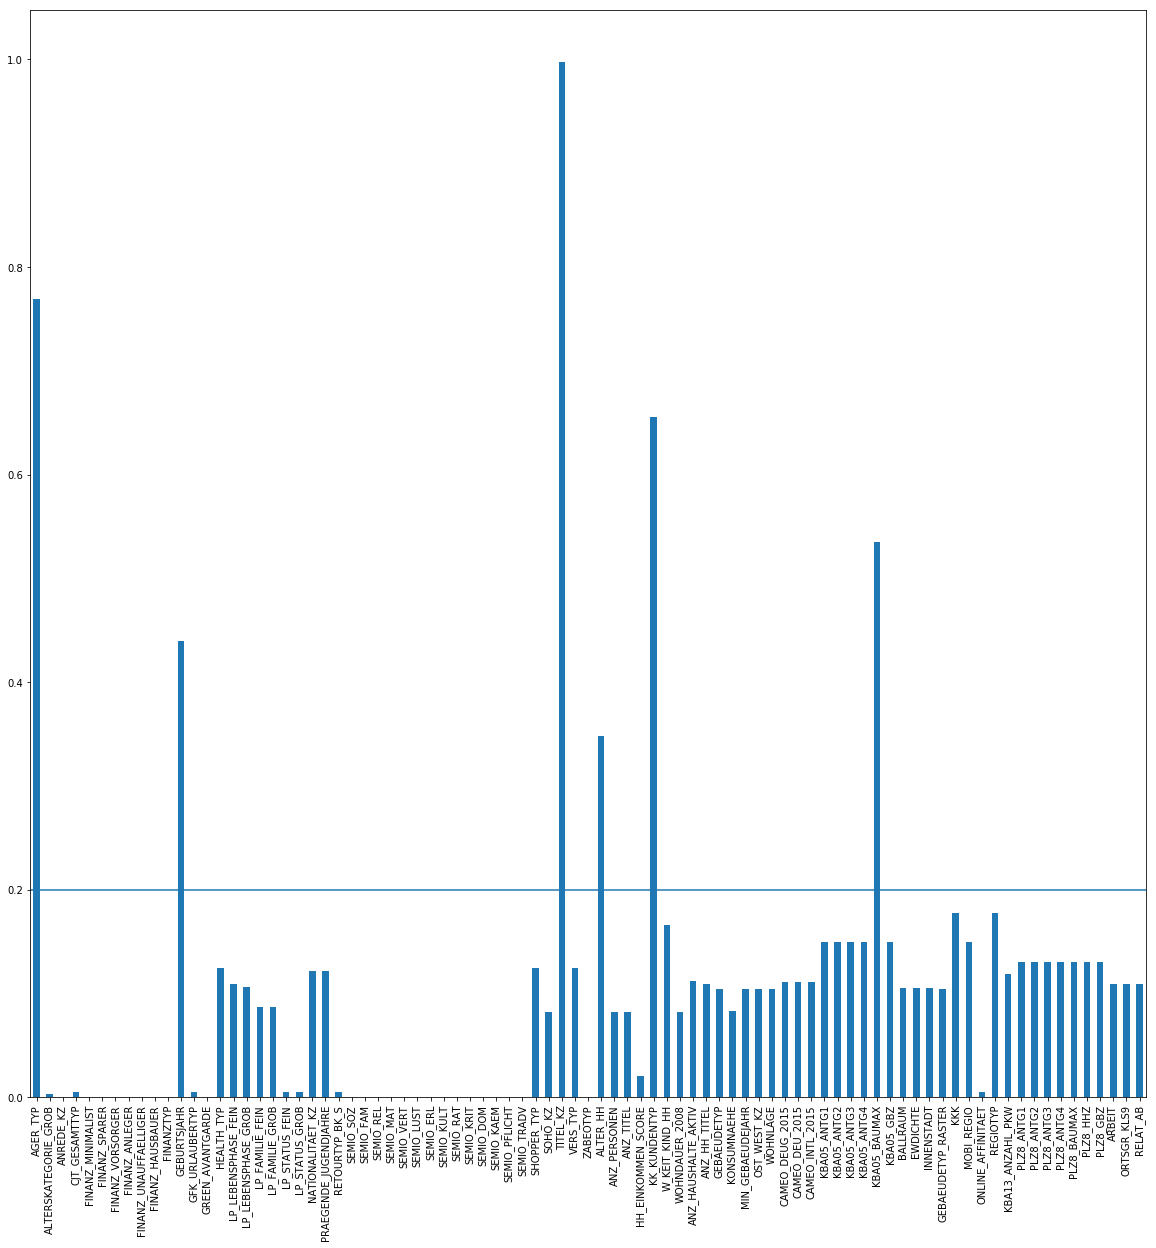

In [25]:
# Investigate patterns in the amount of missing data in each column.
fig = plt.figure(figsize=(20,20))
ax = perc_missing_per_column.plot.bar()
# plt.axhline(y=0.15)
plt.axhline(y=0.20)
plt.show()

# seems that majority of columns are under 20% missing data

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# dropping all columns with > 20% missing data as per the above plot
columns_to_drop = missing_per_column[perc_missing_per_column > .2]
columns_to_drop = columns_to_drop.index.tolist()
print(columns_to_drop)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [27]:
# dropping the column names specified above
azdias.drop(columns_to_drop, axis=1, inplace=True)

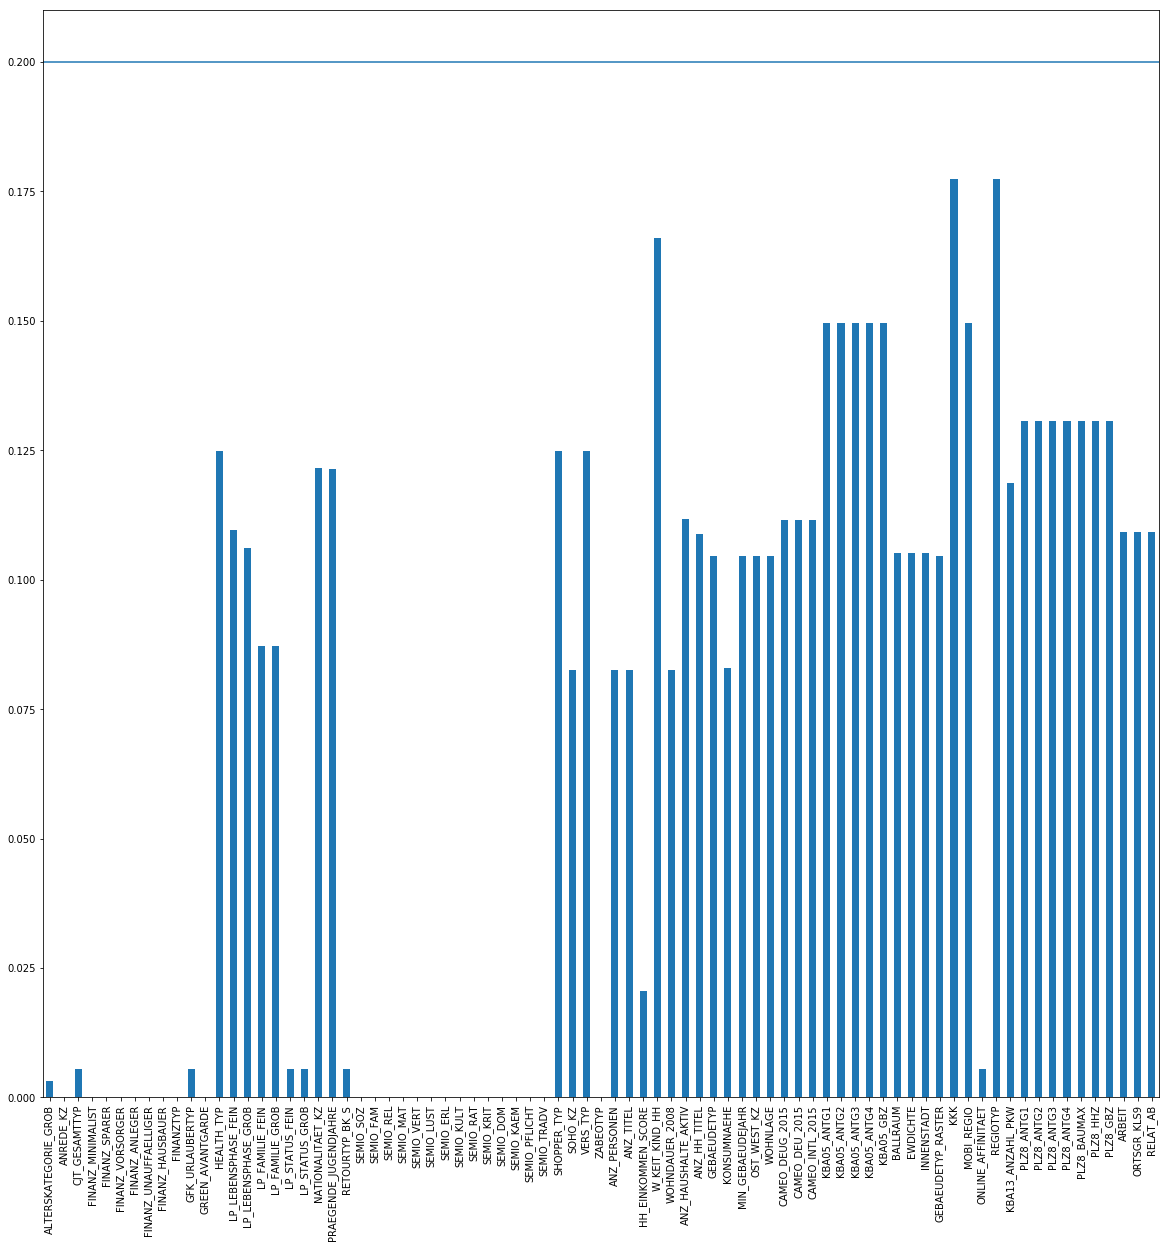

In [28]:
# checking the dropped columns
missing_check = azdias.isnull().sum()
perc_missing_check = missing_check/len(azdias)
fig = plt.figure(figsize=(20,20))
ax = perc_missing_check.plot.bar()
plt.axhline(y=0.20)
plt.show()

# this plot confirms the correct columns have been dropped

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

* ***Missing data analysis with removed columns:***
* Most columns have < 20% missing data, 6 have > 20% missing data and are dropped from further analysis as this was decided as the cut-off point. 'AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP' and 'KBA05_BAUMAX' were removed from the dataset due to this.

* ***Paterns noticed in missing data:***
* Chunks of similar missing data patterns happen in similar columns. PLZ8 - macro-cell features and KBA05 micro-cell features are examples of this. Personality types and financial typology data had no missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [29]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)
perc_missing_per_row = missing_per_row/len(azdias.columns)

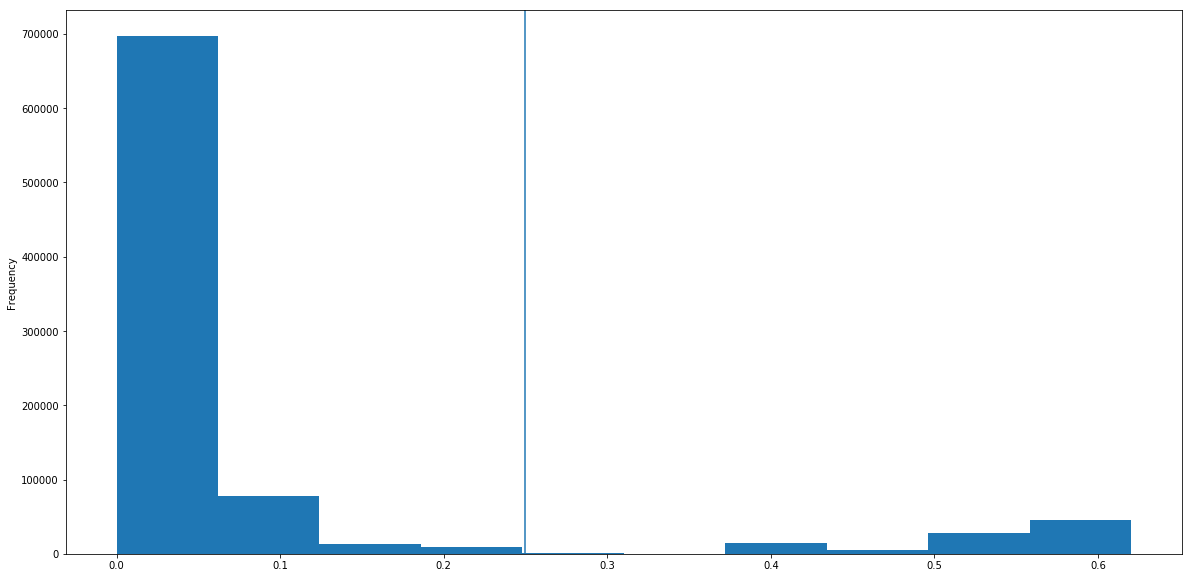

In [30]:
fig = plt.figure(figsize=(20,10))
ax = perc_missing_per_row.plot.hist()
plt.axvline(x=0.25)
plt.show()

In [31]:
# investigating proporations from above plot
# print(np.sum(missing_per_row>(len(azdias.columns)*0.25))) # 94144 rows (too few)
# print()
print(np.sum(missing_per_row==0)) # 623209 rows (~70%)
print()
print(np.sum(missing_per_row!=0)) # 268012 rows (~30%)

623209

268012


In [32]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# best way of splitting from the above analysis is rows where no data is missing and where any data is missing
rows_no_missing = list(np.where(missing_per_row==0)[0])
rows_missing = list(np.where(missing_per_row!=0)[0])

# print(len(rows_no_missing))
# print(len(rows_missing))

azdias_one = azdias.loc[rows_no_missing, :] # dataset with no missing in rows
azdias_two = azdias.loc[rows_missing, :] # dataset with some missing data in rows

# print(len(azdias_one))
# print(len(azdias_two))

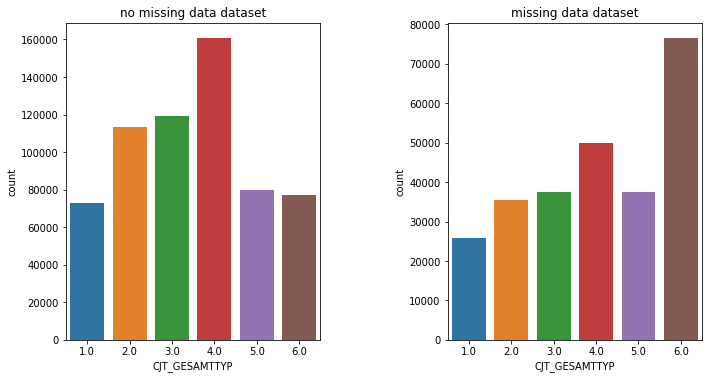

In [33]:
# comparing the distributions of 'CJT_GESAMTTYP' (Customer Journey Typology)
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(data = azdias_one, x = azdias_one['CJT_GESAMTTYP'])
ax1.set_title("no missing data dataset")
plt.subplot(1,2,2)
ax2 = sns.countplot(data = azdias_two, x = azdias_two['CJT_GESAMTTYP'])
ax2.set_title("missing data dataset")

fig.tight_layout()
fig.subplots_adjust(top = 1, wspace = 0.5) # 0.88, wspace=0.4)
plt.show()

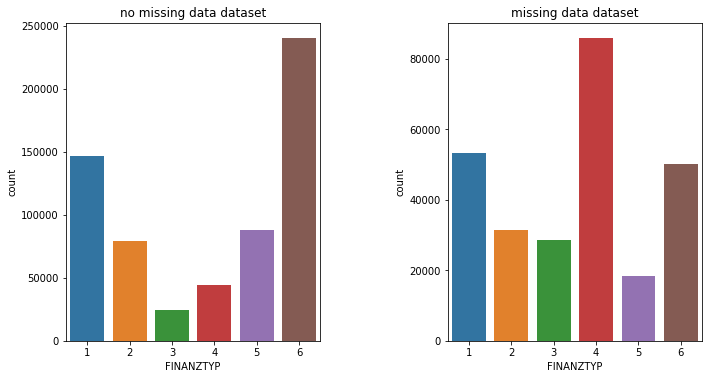

In [34]:
# comparing the distributions of 'FINANZTYP' (Financial Types for Individuals)
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(data = azdias_one, x = azdias_one['FINANZTYP'])
ax1.set_title("no missing data dataset")
plt.subplot(1,2,2)
ax2 = sns.countplot(data = azdias_two, x = azdias_two['FINANZTYP'])
ax2.set_title("missing data dataset")

fig.tight_layout()
fig.subplots_adjust(top = 1, wspace = 0.5) # 0.88, wspace=0.4)
plt.show()

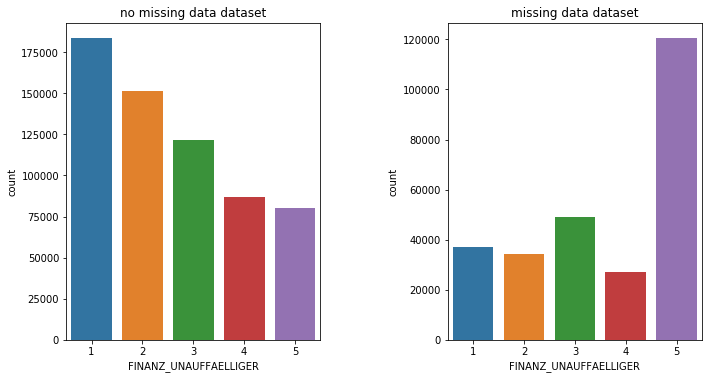

In [35]:
# comparing the distributions of 'FINANZ_UNAUFFAELLIGER' (Financial Typology)
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(data = azdias_one, x = azdias_one['FINANZ_UNAUFFAELLIGER'])
ax1.set_title("no missing data dataset")
plt.subplot(1,2,2)
ax2 = sns.countplot(data = azdias_two, x = azdias_two['FINANZ_UNAUFFAELLIGER'])
ax2.set_title("missing data dataset")

fig.tight_layout()
fig.subplots_adjust(top = 1, wspace = 0.5) # 0.88, wspace=0.4)
plt.show()

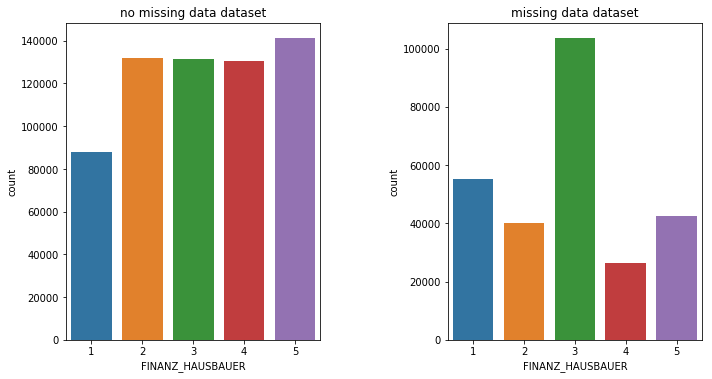

In [36]:
# comparing the distributions of 'FINANZ_HAUSBAUER' (Financial Typology)
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(data = azdias_one, x = azdias_one['FINANZ_HAUSBAUER'])
ax1.set_title("no missing data dataset")
plt.subplot(1,2,2)
ax2 = sns.countplot(data = azdias_two, x = azdias_two['FINANZ_HAUSBAUER'])
ax2.set_title("missing data dataset")

fig.tight_layout()
fig.subplots_adjust(top = 1, wspace = 0.5) # 0.88, wspace=0.4)
plt.show()

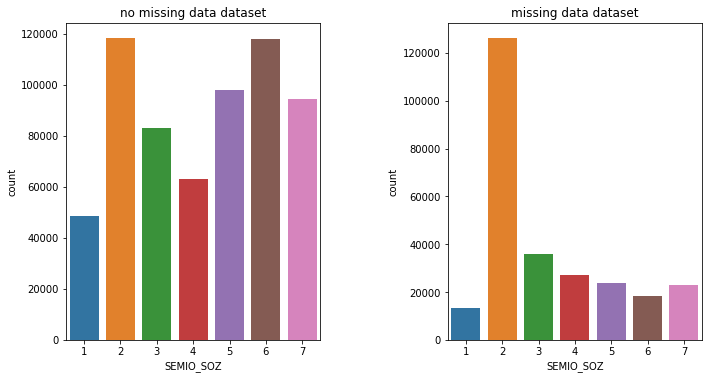

In [37]:
# comparing the distributions of 'SEMIO_SOZ' (Personality Type Dimension)
fig = plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(data = azdias_one, x = azdias_one['SEMIO_SOZ'])
ax1.set_title("no missing data dataset")
plt.subplot(1,2,2)
ax2 = sns.countplot(data = azdias_two, x = azdias_two['SEMIO_SOZ'])
ax2.set_title("missing data dataset")

fig.tight_layout()
fig.subplots_adjust(top = 1, wspace = 0.5) # 0.88, wspace=0.4)
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

# TODO (COMPLETE THIS SECTION)

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

* ~70% of rows had no missing data
* Missing data columns have a much different distibution from the dataset with no missing data, as missing data distributions seemed to be more skewed towards a single value than the no missing data dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [38]:
# How many features are there of each data type?
print(feat_info.type.value_counts())

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [39]:
# Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?
# feat_info # keeping the print df handy ;)
cat_atts = feat_info.loc[feat_info['type'] == 'categorical']['attribute']

cat_df = pd.DataFrame()

cats = []
vals = []
for attribute in cat_atts:
    if attribute in azdias_one.columns.tolist():
        cats.append(attribute)
        # originally had np.isnan==False but it threw a wobbly so I changed it to pd.isnull and it worked...
        # python can be odd at times ;_;
        # only realised I had to use azdias_one for this entire analysis hence the requirements for 
        # nan check is moot... I'm leaving this comment in regardless!
        vals.append(len([i for i in azdias_one[attribute].unique().tolist() if pd.isnull(i)==False]))

# doing some sanity checks
# print([i for i in cat_atts if i not in azdias.columns.tolist()]) # ['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']
# print(len(cat_atts)) # 21
# print(len(cats)) # 18
# print(len(vals)) # 18

cat_df['atts'] = cats
cat_df['num_vals'] = vals
cat_df.loc[cat_df['num_vals'] == 2]

,atts,num_vals
0,ANREDE_KZ,2
4,GREEN_AVANTGARDE,2
11,SOHO_KZ,2
12,VERS_TYP,2
15,OST_WEST_KZ,2


In [40]:
# looking into multi-level categoricals to drop
atts_to_drop = cat_df.loc[cat_df['num_vals'] > 2]
print(atts_to_drop)
azdias_one.drop(atts_to_drop['atts'], axis=1, inplace = True)

In [41]:
# Re-encode categorical variable(s) to be kept in the analysis.
# only variable with binary non numerical unique values is OST_WEST_KZ
# create dict of re-encoding
new_binary_vals = {'O': 0,
                   'W': 1}
# re-encode dataframe
azdias_one.replace({'OST_WEST_KZ':new_binary_vals}, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

* I can drop non-binary categorical columns? Lol, done.

* This resulted in the following columns being dropped: 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015' and 'CAMEO_DEU_2015'

* Only one variable had to be re-encoded 'OST_WEST_KZ' and it was re-encoded using the following dict {'O': 0, 'W': 1}

* Four columns were categorical numerical binary types 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ' and 'VERS_TYP' and they were kept unchanged in the dataset.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# from dictionary.md 'Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)'
# print(azdias_one['PRAEGENDE_JUGENDJAHRE'].describe())
# two new variables
# 1) defining movement type
# 2) defining movement decade
azdias_one['youth_movement'] = azdias_one['PRAEGENDE_JUGENDJAHRE']
azdias_one['youth_decade'] = azdias_one['PRAEGENDE_JUGENDJAHRE']

movement = {# 1: 1,
            # 2: 2,
            3: 1,
            4: 2,
            5: 1,
            6: 2,
            7: 1,
            8: 1,
            9: 2,
            10: 1,
            11: 2,
            12: 1,
            13: 2,
            14: 1,
            15: 2}

decade = {1: 40,
          2: 40,
          3: 50,
          4: 50,
          5: 60,
          6: 60,
          7: 60,
          8: 70,
          9: 70,
          10: 80,
          11: 80,
          12: 80,
          13: 80,
          14: 90,
          15: 90}

azdias_one.replace({'youth_movement':movement}, inplace = True)
azdias_one.replace({'youth_decade':decade}, inplace = True)

In [43]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# from dictionary.md 'Wealth / Life Stage Typology, mapped to international code'
# print(azdias_one['CAMEO_INTL_2015'].describe())
# two new variables
# 1) household wealth (5 categories)
# 2) household life stage
azdias_one['house_wealth'] = azdias_one['CAMEO_INTL_2015']
azdias_one['house_life_stage'] = azdias_one['CAMEO_INTL_2015']

wealth = {11: 5,
          12: 5,
          13: 5,
          14: 5,
          15: 5,
          21: 4,
          22: 4,
          23: 4,
          24: 4,
          25: 4,
          31: 3,
          32: 3,
          33: 3,
          34: 3,
          35: 3,
          41: 2,
          42: 2,
          43: 2,
          44: 2,
          45: 2,
          51: 1,
          52: 1,
          53: 1,
          54: 1,
          55: 1}

life_stage = {11: 1,
              12: 2,
              13: 3,
              14: 4,
              15: 5,
              21: 1,
              22: 2,
              23: 3,
              24: 4,
              25: 5,
              31: 1,
              32: 2,
              33: 3,
              34: 4,
              35: 5,
              41: 1,
              42: 2,
              43: 3,
              44: 4,
              45: 5,
              51: 1,
              52: 2,
              53: 3,
              54: 4,
              55: 5}

azdias_one.replace({'house_wealth':wealth}, inplace = True)
azdias_one.replace({'house_life_stage':life_stage}, inplace = True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

* Converted PRAEGENDE_JUGENDJAHRE to two new columns: youth_movement and youth_decade

* Converted CAMEO_INTL_2015 to two new columns: house_wealth and house_life_stage

* PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were then also dropped in the code cell below


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [44]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# drop the two variables used to re-engineer in the above section
azdias_one.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
azdias_one.drop('CAMEO_INTL_2015', axis = 1, inplace = True)

In [45]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [46]:
feat_info['split_missing'][57]

[-1, 'X']

In [47]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for i in range(len(feat_info['attribute'])):
        df[feat_info['attribute'][i]] = df[feat_info['attribute'][i]].replace(feat_info['split_missing'], np.nan)
        df[feat_info['attribute'][i]] = df[feat_info['attribute'][i]].replace('XX', np.nan)
    
    # remove selected columns and rows, ... (assuming we're following the same steps as before)
    # drop the same columns
    atts_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df.drop(atts_to_drop, axis=1, inplace=True)
    
    # selecting rows with no missing data
    missing_rows = df.isnull().sum(axis = 1)
    no_missing_data_rows = list(np.where(missing_rows == 0)[0])
    df = df.loc[no_missing_data_rows, :]
    
    # select, re-encode, and engineer column values.
    df.replace({'OST_WEST_KZ':{'W': 1, 'O': 0}}, inplace=True)
    
    # dropping the same categorical columns with more than two values
    atts_to_drop = ['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN',
                    'LP_FAMILIE_GROB','LP_STATUS_FEIN','LP_STATUS_GROB','NATIONALITAET_KZ',
                    'SHOPPER_TYP','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015']
    df.drop(atts_to_drop, axis=1, inplace=True)
    
    # creating the same creates variables from PRAEGENDE_JUGENDJAHRE
    df['youth_movement'] = df['PRAEGENDE_JUGENDJAHRE']
    df['youth_decade'] = df['PRAEGENDE_JUGENDJAHRE']

    movement = {# 1: 1,
                # 2: 2,
                3: 1,
                4: 2,
                5: 1,
                6: 2,
                7: 1,
                8: 1,
                9: 2,
                10: 1,
                11: 2,
                12: 1,
                13: 2,
                14: 1,
                15: 2}

    decade = {1: 40,
              2: 40,
              3: 50,
              4: 50,
              5: 60,
              6: 60,
              7: 60,
              8: 70,
              9: 70,
              10: 80,
              11: 80,
              12: 80,
              13: 80,
              14: 90,
              15: 90}

    df.replace({'youth_movement':movement}, inplace = True)
    df.replace({'youth_decade':decade}, inplace = True)
    
    # creating the same creates variables from CAMEO_INTL_2015
    df['house_wealth'] = df['CAMEO_INTL_2015']
    df['house_life_stage'] = df['CAMEO_INTL_2015']

    wealth = {11: 5,
              12: 5,
              13: 5,
              14: 5,
              15: 5,
              21: 4,
              22: 4,
              23: 4,
              24: 4,
              25: 4,
              31: 3,
              32: 3,
              33: 3,
              34: 3,
              35: 3,
              41: 2,
              42: 2,
              43: 2,
              44: 2,
              45: 2,
              51: 1,
              52: 1,
              53: 1,
              54: 1,
              55: 1}

    life_stage = {11: 1,
                  12: 2,
                  13: 3,
                  14: 4,
                  15: 5,
                  21: 1,
                  22: 2,
                  23: 3,
                  24: 4,
                  25: 5,
                  31: 1,
                  32: 2,
                  33: 3,
                  34: 4,
                  35: 5,
                  41: 1,
                  42: 2,
                  43: 3,
                  44: 4,
                  45: 5,
                  51: 1,
                  52: 2,
                  53: 3,
                  54: 4,
                  55: 5}

    df.replace({'house_wealth':wealth}, inplace = True)
    df.replace({'house_life_stage':life_stage}, inplace = True)
    
    # drop original columns
    df.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    df.drop('CAMEO_INTL_2015', axis = 1, inplace = True)
    
    # Return the cleaned dataframe.
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [48]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# checking the nan values in azdias_one
azdias_one.isnull().sum().sum() # 0

0

In [49]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()

azdias_one_scaled = scaler.fit_transform(azdias_one)
azdias_one_scaled = pd.DataFrame(azdias_one_scaled, columns = list(azdias_one))

### Discussion 2.1: Apply Feature Scaling

# TODO Complete once code is done

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

* There was no missing data so imputation wasn't required
* Scaling was required due to the fact that dimension reduction techniques would be skewed if the dataset wasn't standardised before being applied. So I used the StandardScaler() to achieve this.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [50]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_one_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

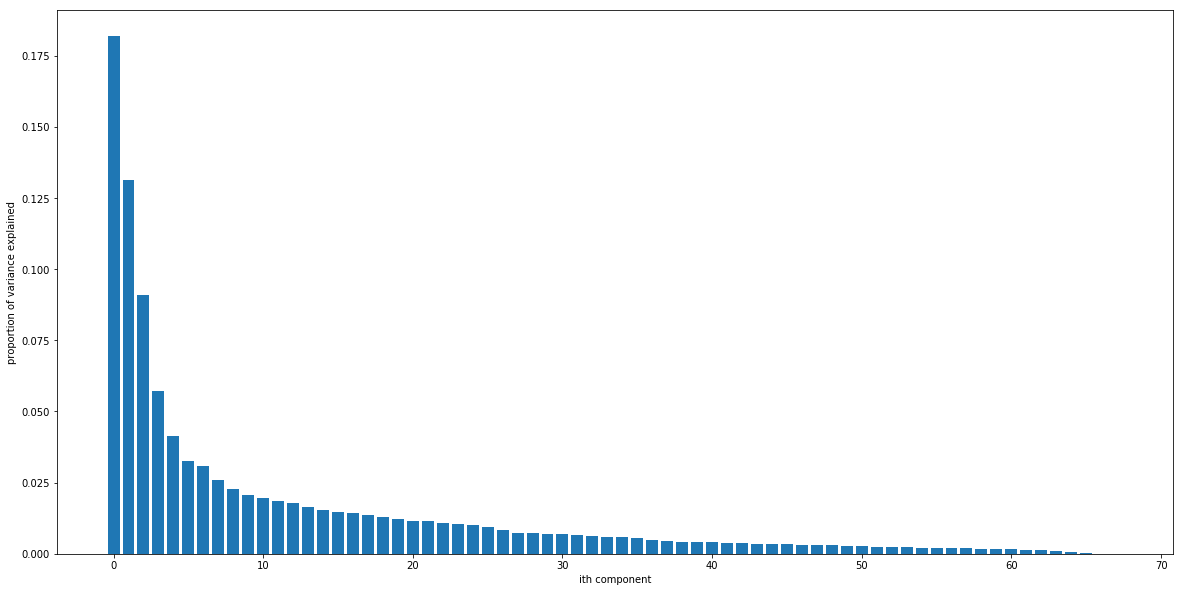

In [51]:
# Investigate the variance accounted for by each principal component.
# doing this by plotting
fig = plt.figure(figsize=(20, 10))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("ith component")
plt.ylabel("proportion of variance explained")
plt.show()

In [52]:
# and then plotting the cumulative variance (and first calculating it)
cumulative_var = []
for i in range(1, len(pca.explained_variance_ratio_) + 1):
    cumulative_var.append(sum(pca.explained_variance_ratio_[0:i]))
    
# print(cumulative_var)

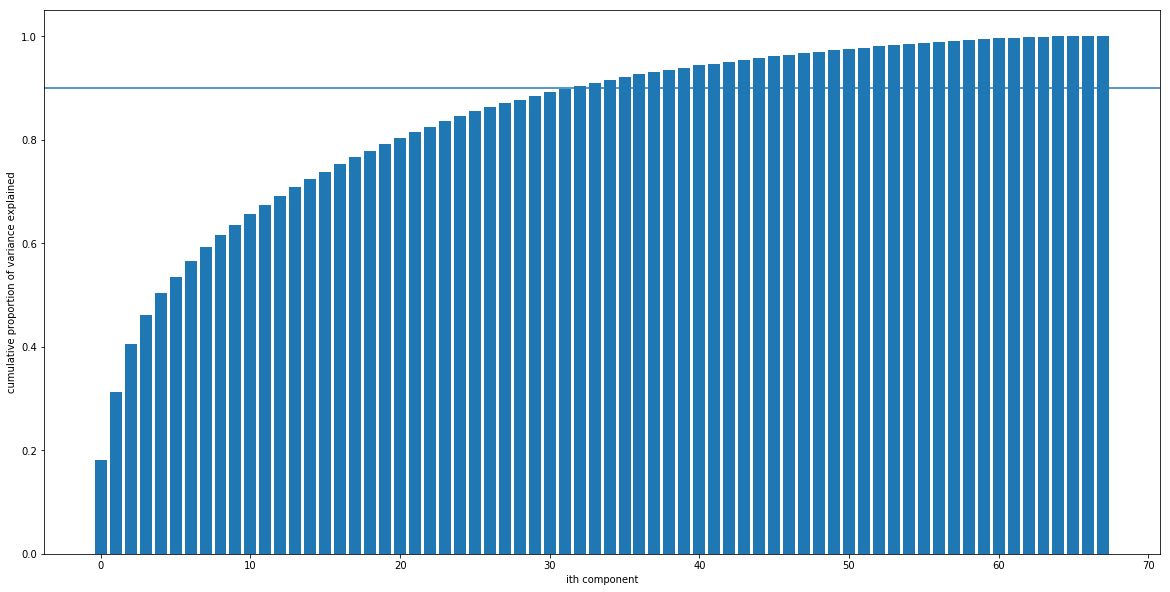

In [53]:
fig = plt.figure(figsize=(20,10))
plt.bar(range(len(cumulative_var)), cumulative_var)
plt.xlabel("ith component")
plt.ylabel("cumulative proportion of variance explained")
plt.axhline(y=.90)
plt.show()

In [54]:
# 90% variance explained looks good, now to find out how many components that is
min_over_ninty_val = min([i for i in cumulative_var if i > 0.9])
num_components = cumulative_var.index(min_over_ninty_val) + 1

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = num_components)
azdias_pca = pca.fit_transform(azdias_one_scaled)
azdias_pca = pd.DataFrame(azdias_pca)

In [56]:
azdias_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,3.257277,-3.006241,-3.024424,-0.352047,-0.127570,3.242834,1.841147,0.300677,-1.011396,0.324014,-0.779008,1.532473,-1.049929,-2.268982,0.810281,10.822845,-1.293147,-0.520461,-0.155747,1.056611,-1.092245,-0.872376,-0.512394,-0.108383,1.001977,-0.030509,0.498110,-0.732674,0.453717,-0.133617,-0.666030,-0.132454,-0.900445
1,-0.855811,0.218511,-3.090431,1.633787,-2.820014,-0.676158,-0.088730,-0.254579,-1.208327,0.041859,1.078435,1.067800,-1.760131,0.479241,0.929154,-0.161262,1.112561,-1.366255,-0.436007,-1.747410,0.645270,0.327784,-0.719437,-1.337265,0.381004,-0.136739,0.378390,-0.287596,-0.787101,-0.668608,1.277960,-0.183018,-0.327139
2,0.227994,0.108566,3.240181,1.460770,2.882236,0.619767,-3.239612,0.809225,-0.990096,1.670979,-0.029425,0.717921,-0.617539,0.582344,-1.165847,-0.103613,0.536462,-0.190778,-0.139597,-0.001918,-0.377747,1.378658,0.412163,-1.082275,-0.295833,-0.810362,-0.065886,-0.524929,-0.110342,0.964008,0.121049,0.751346,0.186516
3,-0.468465,-1.411151,-1.183800,-3.229705,-2.208731,1.846241,-0.920573,0.084198,2.336848,0.618587,-2.809483,0.295091,1.369826,-0.994134,1.299740,-0.054661,-2.742610,1.129176,-1.002462,-0.100613,-0.456126,0.669140,0.864996,-0.360536,0.716235,-1.251552,-0.152125,1.290282,0.052412,0.324891,0.837919,0.240945,-0.502450
4,-0.113057,-3.284452,-3.676291,-0.997491,-2.274327,0.024301,-1.131080,0.192355,2.385123,-1.323157,-0.113299,0.235969,0.107009,0.414296,-0.651045,-0.071692,0.975204,-1.777098,0.835315,-0.131657,-0.080919,1.235391,-0.546815,-0.262504,-2.062751,-0.232630,0.572346,0.019367,-0.178562,0.442713,0.944352,-0.503813,-0.035012


In [57]:
azdias_pca.shape

(623209, 33)

In [58]:
# creating dataframe with column names included
# azdias_one_scaled.head()
pca_explaination = pd.DataFrame(np.transpose(pca.components_), index = azdias_one_scaled.columns.tolist())

In [59]:
pca_explaination.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
ALTERSKATEGORIE_GROB,-0.102443,0.268226,0.080293,-0.037894,0.031052,0.029029,-0.007189,-0.030083,-0.077445,-0.059967,0.137855,-0.028305,0.006449,-0.022405,-0.079417,-0.001187,0.167560,-0.056409,0.052415,-0.049341,0.010263,0.005134,-0.090165,0.057697,-0.038059,-0.006021,-0.041519,0.051121,-0.018153,-0.042783,0.035321,-0.087486,-0.018287
ANREDE_KZ,0.003104,0.083951,-0.368498,0.044557,0.001186,-0.007724,0.025212,-0.062528,0.086702,-0.027459,0.016678,-0.010476,0.010280,-0.003323,0.046860,-0.000453,-0.056617,0.018966,-0.023125,0.023728,-0.006469,-0.005020,0.063600,-0.027377,0.000425,-0.006046,0.020809,-0.087745,-0.071281,0.002576,-0.023981,0.024465,0.010072
FINANZ_MINIMALIST,-0.199928,0.084224,0.162344,0.052985,0.037020,-0.062852,-0.023442,0.042617,0.059344,0.006904,-0.174074,-0.081270,0.140962,-0.072018,-0.025250,0.002940,0.083008,0.090857,0.072255,-0.057801,0.045780,0.000243,-0.018045,0.081379,0.035156,-0.037289,-0.215076,-0.049065,0.075721,-0.020411,-0.153164,0.152841,0.043030
FINANZ_SPARER,0.122703,-0.244665,-0.100612,0.002929,0.001575,0.009366,0.000583,0.049792,-0.162467,-0.051599,0.150206,0.016342,-0.024602,-0.007401,0.008887,-0.002804,0.060825,-0.159217,0.022013,-0.021425,-0.034822,0.030669,0.021340,-0.004091,-0.074952,0.036109,0.088267,0.044506,0.009581,-0.011315,-0.009511,0.034706,0.027704
FINANZ_VORSORGER,-0.097119,0.235142,0.096435,-0.018740,-0.018268,0.054344,-0.034920,-0.000794,0.183250,0.157069,-0.078588,0.017048,-0.031318,-0.006072,0.034922,0.001677,-0.139650,0.204825,-0.087253,0.132413,0.002144,-0.047377,0.025765,-0.064071,0.122314,-0.102002,0.002274,0.010839,-0.027418,0.062626,0.102118,-0.127192,-0.034126


### Discussion 2.2: Perform Dimensionality Reduction

I performed the inital PCA and found that the first 33 components accounted for 90% of the variability in the dataset. So I kept 33 in the second iteration of creating PCA components. I could have probably chosen 20 PCs top get ~78% variability but more than halving the columns for only a 10% reduction in variance explained sounded good enough for me.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [60]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_compare(pca, i, top_features = 5):
    series = pca.iloc[:, i]
    print ("Top {} negative features for component {}".format(top_features, i))
    print (series.sort_values(ascending = True)[:top_features])
    print ("Top {} positive features for component {}".format(top_features, i))
    print (series.sort_values(ascending = False)[:top_features])

In [61]:
# First PCA
pca_compare(pca_explaination, 0, 5)

Top 5 negative features for component 0
MOBI_REGIO          -0.232548
PLZ8_ANTG1          -0.218264
KBA05_ANTG1         -0.217510
KBA05_GBZ           -0.207866
FINANZ_MINIMALIST   -0.199928
Name: 0, dtype: float64
Top 5 positive features for component 0
PLZ8_ANTG3          0.216415
PLZ8_ANTG4          0.210281
PLZ8_BAUMAX         0.206490
house_life_stage    0.198598
house_wealth        0.198598
Name: 0, dtype: float64


In [62]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_compare(pca_explaination, 1, 5)

Top 5 negative features for component 1
SEMIO_REL       -0.269332
youth_decade    -0.256170
SEMIO_PFLICHT   -0.245946
FINANZ_SPARER   -0.244665
SEMIO_TRADV     -0.236799
Name: 1, dtype: float64
Top 5 positive features for component 1
ALTERSKATEGORIE_GROB    0.268226
SEMIO_ERL               0.236426
FINANZ_VORSORGER        0.235142
SEMIO_LUST              0.185810
RETOURTYP_BK_S          0.165483
Name: 1, dtype: float64


In [63]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_compare(pca_explaination, 2, 5)

Top 5 negative features for component 2
ANREDE_KZ    -0.368498
SEMIO_KAEM   -0.339006
SEMIO_DOM    -0.312734
SEMIO_KRIT   -0.271358
SEMIO_RAT    -0.217557
Name: 2, dtype: float64
Top 5 positive features for component 2
SEMIO_VERT           0.349635
SEMIO_SOZ            0.263984
SEMIO_FAM            0.251980
SEMIO_KULT           0.233125
FINANZ_MINIMALIST    0.162344
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

# TODO Complete this once code is done

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Only looking at top 5 and bottom 5 columns due to reasons of sanity.

***Feature 1:***
* ***Top 5 negative features for component 0***
* MOBI_REGIO          -0.232548 (Movement patterns, lower number is higher movement)
* PLZ8_ANTG1          -0.218264 (Number of 1-2 houses in region, higher is more share)
* KBA05_ANTG1         -0.217510 (Number of 1-2 houses in micro-cell, higher is more share)
* KBA05_GBZ           -0.207866 (Number of buildings in micro-cell, higher is more)
* FINANZ_MINIMALIST   -0.199928 (Low financial interest, higher number is lower interest)
* ***Top 5 positive features for component 0***
* PLZ8_ANTG3          0.216415 (Number of 6-8 family houses, higher is more)
* PLZ8_ANTG4          0.210281 (Number of 10+ family houses, higher is more)
* PLZ8_BAUMAX         0.206490 (Most common building, higher is higher capacity buildings)
* house_life_stage    0.198598 (life stage, higher is more elderly)
* house_wealth        0.198598 (house wealth, higher is more wealthy)

***Summary:*** This feature has a high negative effect on lower capacity housing, people with higher movement and lower financial interest of owning a home. It has a high positive effect on larger capacity houses with more elderly and wealthy individuals. Therefore, overall I'd say this feature focuses on housing density, life stage and wealth.

***Feature 2:***
* ***Top 5 negative features for component 1***
* SEMIO_REL       -0.269332 (Personality Typology religious, lower is highest affinity)
* youth_decade    -0.256170 (decade of youth_movement, lower is earlier movement decade)
* SEMIO_PFLICHT   -0.245946 (Personality Typology dutiful, lower is highest affinity)
* FINANZ_SPARER   -0.244665 (Financial Typology money-saver, lower is higher afinity)
* SEMIO_TRADV     -0.236799 (Personality Typology traditional-minded, lower is highest affinity)
* ***Top 5 positive features for component 1***
* ALTERSKATEGORIE_GROB    0.268226 (Estimated age, higher is older)
* SEMIO_ERL               0.236426 (Personality Typology event-orientated, lower is highest affinity)
* FINANZ_VORSORGER        0.235142 (Financial Typology be prepared, lower is higher afinity)
* SEMIO_LUST              0.185810 (Personality Typology sensual-minded, lower is highest affinity)
* RETOURTYP_BK_S          0.165483 (Return type (influenceable to advertise to?), higher is crazy shopper)

***Summary:*** This feature seems to be focusing negatively on the more impulsive, sensual, even-orientated and easy to influence people (age is an odd one here, but maybe it's saying the ages in this population are more uniformly distributed at the 9 value?) and positively focused on decade of youth (backing up the age claim), dutiful, money-saver, religious and traditional type of people. I'd say there seems to be a negative youthful mindset and positive elderly mindset in this feature.

***Feature 3:***
* ***Top 5 negative features for component 2***
* ANREDE_KZ    -0.368498 (Gender, 1:male 2:female)
* SEMIO_KAEM   -0.339006 (Personality Typology combative, lower is highest affinity)
* SEMIO_DOM    -0.312734 (Personality Typology dominant, lower is highest affinity)
* SEMIO_KRIT   -0.271358 (Personality Typology critical-minded, lower is highest affinity)
* SEMIO_RAT    -0.217557 (Personality Typology rational, lower is highest affinity)
* ***Top 5 positive features for component 2***
* SEMIO_VERT           0.349635 (Personality Typology dreamful, lower is highest affinity)
* SEMIO_SOZ            0.263984 (Personality Typology social, lower is highest affinity)
* SEMIO_FAM            0.251980 (Personality Typology family, lower is highest affinity)
* SEMIO_KULT           0.233125 (Personality Typology cultural, lower is highest affinity)
* FINANZ_MINIMALIST    0.162344 (Financial Typology minimalist, lower is lower financial interest)

***Summary:*** This feature seems to be negatively focus on males that are combative, dominant, critical-minded and rational and positively on dreamful, social, cultural people with low financial interest. I'd say this is a personality type of combative critical thinking males vs dreamful artist play off here. With a positive focus on the artist.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [64]:
# %%time # Added this for curiosity
# Over a number of different cluster counts...
scores = {}
start_clusters = 2
end_clusters = 12
for n_clusters in range(start_clusters, end_clusters):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(azdias_pca)
    scores[n_clusters] = np.abs(kmeans.score(azdias_pca))
    print("Completed running {} cluster model".format(n_clusters))

Completed running 2 cluster model
Completed running 3 cluster model
Completed running 4 cluster model
Completed running 5 cluster model
Completed running 6 cluster model
Completed running 7 cluster model
Completed running 8 cluster model
Completed running 9 cluster model
Completed running 10 cluster model
Completed running 11 cluster model


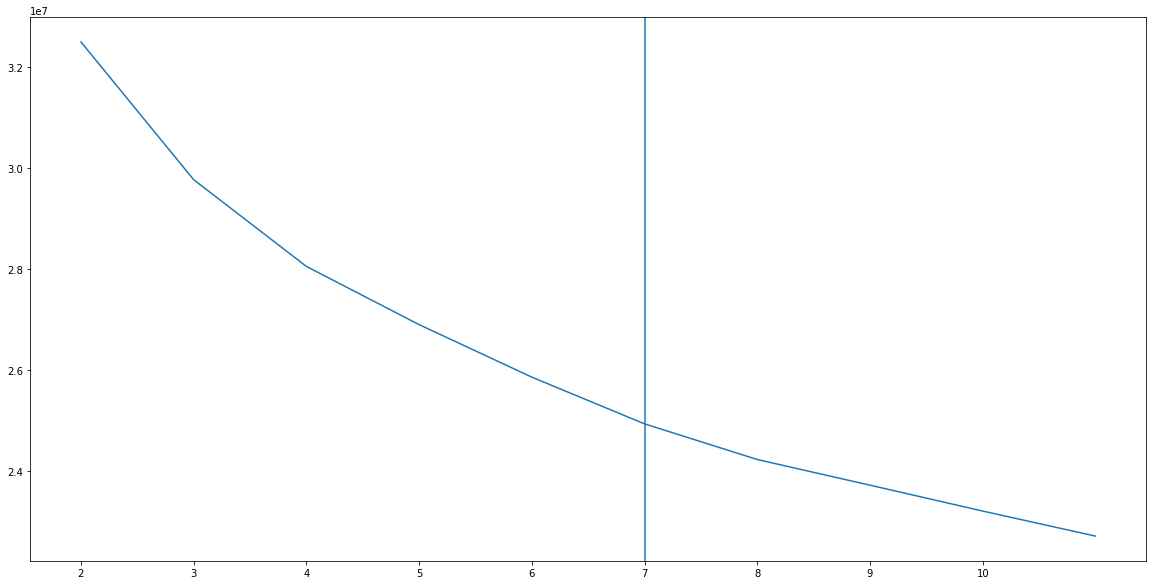

In [65]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# put in series for easier plotting
score_series = pd.Series(scores)
plt.figure(num=None, figsize=(20, 10))
plt.plot(score_series)
plt.xticks(np.arange(2, 11, step=1))
plt.axvline(x=7)

In [66]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 7)
kmeans.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

* The plot above seemed to have an elbow (or to flatten more out) at the 7 mark
* Therefore I chose 7 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [67]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv',delimiter = ";" )

In [68]:
customers.shape

(191652, 85)

In [69]:
# apply pre-processing to customers data using clean_data function
customers_cleaned = clean_data(customers)

In [70]:
# double checking null values
customers_cleaned.isnull().sum().sum()

0

In [71]:
# apply feature transformation to customers_cleaned dataset
scaler2 = StandardScaler()
customers_cleaned_scaled = scaler2.fit_transform(customers_cleaned)

In [72]:
# create into DataFrame 
customers_cleaned_scaled = pd.DataFrame(customers_cleaned_scaled, columns = customers_cleaned.columns.tolist())
customers_cleaned_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,youth_movement,youth_decade,house_wealth,house_life_stage
0,-0.671933,-0.697741,-1.262924,-0.502403,-0.704717,2.440844,3.389254,-0.584726,-1.035331,1.257578,0.530574,0.665564,0.917613,-0.238346,0.683305,0.559166,1.304857,-0.095232,0.262967,-0.504426,0.610884,1.553308,-0.496555,0.619731,-0.883432,1.390695,0.787715,-0.099521,0.909510,1.198624,-0.137694,1.653596,-1.202435,0.275147,0.168172,-0.13065,-1.494302,-0.330161,0.292849,-0.351181,-1.622746,1.658394,2.239054,-0.31328,-0.555845,-0.615317,0.073903,-0.402886,-1.038068,1.525758,-0.516137,1.493712,1.542156,-0.451075,-0.602838,1.513976,0.694012,0.726148,0.380841,-0.678997,-0.617719,0.172904,-0.053268,-1.335659,-0.991215,0.843032,0.864839,0.864839
1,-0.671933,-0.697741,0.712882,-0.502403,0.502192,-0.588682,0.204187,0.185016,0.965875,1.257578,-0.596402,-0.556854,-0.765599,1.002263,0.077690,0.559166,-1.225793,1.053244,0.262967,-0.504426,1.185062,-0.625460,0.634612,0.619731,-0.326018,0.004176,0.787715,-0.099521,0.909510,-0.300339,-0.137694,-1.346872,0.907825,0.275147,-0.284930,-0.13065,-0.797232,-0.330161,0.292849,-1.318944,-0.171801,0.733022,0.920054,-0.31328,-0.555845,1.276617,0.696534,1.638987,0.175020,-0.292920,-0.516137,0.003364,-0.390214,1.478922,-0.602838,0.320620,0.694012,0.726148,-0.466939,1.469793,1.369984,0.172904,0.873524,1.476707,0.968354,-0.601571,0.351127,0.351127
2,0.654647,-0.697741,0.712882,-0.502403,0.502192,-0.588682,-0.857502,-0.584726,0.965875,0.079562,-0.354907,-0.556854,0.917613,-0.238346,-1.133540,1.247791,-1.225793,0.479006,-0.367491,-1.076455,0.036705,0.100796,-0.496555,-1.907930,-0.883432,-0.689083,0.787715,-0.099521,-0.801794,-0.300339,-0.137694,-0.746778,0.907825,0.275147,-0.284930,-0.13065,0.596906,-0.330161,0.292849,1.584343,1.279143,-0.192350,-0.398946,-0.31328,0.308668,0.803634,-1.171359,0.107582,0.175020,-0.292920,0.271773,0.748538,-0.390214,1.871414,0.501318,-0.872736,-0.437501,-0.845572,-0.466939,1.469793,1.369984,-0.815958,-0.980061,-0.632567,0.968354,-0.601571,-0.456134,-0.456134
3,0.654647,-0.697741,0.712882,-0.502403,0.502192,-0.588682,0.204187,-0.584726,0.965875,-1.098454,-0.354907,-0.556854,0.917613,1.002263,0.077690,1.247791,1.304857,1.053244,0.893425,-1.076455,0.036705,-1.351716,-0.496555,-0.644100,-1.440846,-1.382342,-1.387803,-0.099521,-0.801794,-0.300339,-0.137694,-1.346872,0.907825,0.275147,-0.284930,-0.13065,-0.100163,-0.330161,0.292849,-0.351181,0.553671,0.733022,-0.398946,-0.31328,0.308668,0.330650,-0.548728,0.107582,0.175020,-1.202259,0.271773,0.003364,-1.356399,-0.545509,0.501318,0.320620,-0.437501,0.726148,-0.466939,-0.678997,-0.617719,0.172904,-0.516665,0.070524,0.968354,-0.601571,-1.043234,-1.043234
4,-0.671933,-0.697741,0.712882,0.724012,-0.704717,-0.588682,1.265876,-1.354468,0.965875,1.257578,0.289079,0.176597,-1.607205,1.002263,0.077690,0.559166,-1.225793,1.053244,-0.997949,-0.504426,0.610884,-0.625460,-0.496555,0.619731,-0.326018,0.004176,0.787715,-0.099521,0.909510,0.449142,-0.137694,-1.346872,-1.202435,0.275147,-0.284930,-0.13065,1.293975,2.731049,0.292849,0.616581,-0.171801,0.733022,-0.398946,-0.31328,0.308668,-1.088300,0.696534,-0.402886,0.175020,-0.292920,0.271773,1.493712,1.059064,1.298907,0.501318,0.320620,-0.437501,-0.84557

In [73]:
# reduce dem dimensions
customers_pca = pca.transform(customers_cleaned_scaled)
customers_pca.shape

(123173, 33)

In [74]:
# put the pca into a DataFrame
customers_pca_df = pd.DataFrame(customers_pca)
customers_pca_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,3.890337,-3.057262,-0.632553,-0.324471,2.144810,1.621527,-2.141499,-0.138087,-0.677892,2.499738,0.670900,-1.169579,0.788839,1.020839,0.324733,-0.144045,0.570812,-0.585938,-0.619513,-0.779507,0.811798,-0.456729,-1.108102,1.081431,-0.965577,0.820355,0.561473,-0.200022,0.973645,0.688538,0.608709,0.233839,0.163210
1,0.465872,0.065221,1.633687,1.268109,-2.491195,1.306176,-1.656686,0.486132,-1.089453,-0.564615,-1.368369,1.395794,-0.077288,-1.395322,1.295167,-0.061315,-1.079950,0.705217,0.210562,0.762187,0.981120,-0.664373,-1.063540,0.687045,0.928348,-0.185075,-0.335497,-0.359001,-0.695932,0.687993,-0.893225,0.581839,0.110999
2,-3.451847,-0.543158,1.628114,-0.828733,-2.105480,1.320331,0.718756,0.091558,0.483461,-0.972145,-0.497411,-0.448710,0.292168,-0.309319,0.806387,-0.108242,-0.710087,0.759891,0.113076,-0.750241,0.041251,-0.314657,1.323952,-1.247631,-0.211172,-0.895606,-0.267989,-0.073976,0.805463,1.315479,0.197931,0.679295,0.189047
3,-2.134720,0.407873,3.373818,0.784235,-1.392909,-1.656835,0.513084,-1.738247,-0.068404,0.061494,1.000112,-0.090157,-0.332437,-0.462287,-0.023035,-0.089207,0.217653,-0.434717,0.504622,0.360276,0.302018,0.335408,-0.447651,-0.490386,-0.581465,0.237457,0.073834,-0.341301,-0.106400,0.342430,-0.362398,0.395614,0.329197
4,-1.697349,-2.919422,0.705052,2.310150,-0.491310,0.908357,-1.277126,2.248821,-1.747458,-1.250185,-0.844933,-0.036903,0.004951,0.974669,0.066409,-0.108971,1.313723,-0.309596,-1.667221,1.302868,0.310399,-0.103916,0.159963,-0.765008,0.594221,-2.041865,-0.948391,-0.540420,-0.272401,-0.281475,0.402971,0.597032,-0.234614


In [75]:
# cluster general demographics dataset to customer data to get cluster prediction
customer_kmeans = kmeans.predict(customers_pca_df)
customer_kmeans.shape

(123173,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [76]:
# getting percent counts for each cluster for pop data
cluster, counts = np.unique(kmeans.labels_, return_counts=True)
pop_clusters = pd.DataFrame({'cluster' : cluster, 'counts': counts})
total_population = pop_clusters['counts'].sum()
pop_clusters['percent'] = pop_clusters['counts'].map(lambda x : x*100/total_population)
print(pop_clusters)

   cluster  counts    percent
0        0   88386  14.182401
1        1  110482  17.727921
2        2  109208  17.523495
3        3   66948  10.742464
4        4   89738  14.399343
5        5   74219  11.909167
6        6   84228  13.515209


In [77]:
# getting percent counts for each cluster for customer data
cluster, counts = np.unique(customer_kmeans, return_counts=True)
cust_clusters = pd.DataFrame({'cluster' : cluster, 'counts': counts})
total_population = cust_clusters['counts'].sum()
cust_clusters['percent'] = cust_clusters['counts'].map(lambda x : x*100/total_population)
print(cust_clusters)

   cluster  counts    percent
0        0   21628  17.559043
1        1   40261  32.686547
2        2   16128  13.093779
3        3    6206   5.038442
4        4   14759  11.982334
5        5    7042   5.717162
6        6   17149  13.922694


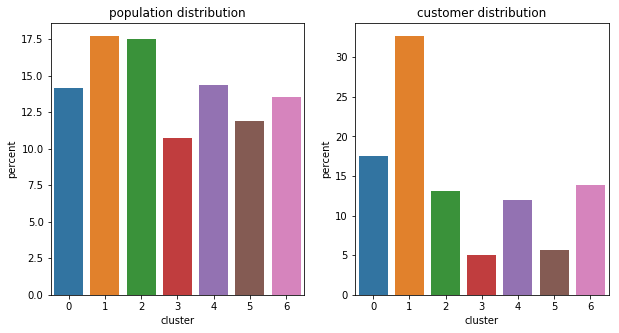

In [78]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, axes = plt.subplots(1,2, figsize=(10, 5))
ax = sns.barplot(x = 'cluster', y = 'percent', data = pop_clusters, ax = axes[0])
ax.set_title('population distribution')
ax = sns.barplot(x = 'cluster', y = 'percent', data = cust_clusters, ax= axes[1])
ax.set_title('customer distribution')
plt.show()

In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
pca_compare(pca_explaination, 1, 5)

Top 5 negative features for component 1
SEMIO_REL       -0.269332
youth_decade    -0.256170
SEMIO_PFLICHT   -0.245946
FINANZ_SPARER   -0.244665
SEMIO_TRADV     -0.236799
Name: 1, dtype: float64
Top 5 positive features for component 1
ALTERSKATEGORIE_GROB    0.268226
SEMIO_ERL               0.236426
FINANZ_VORSORGER        0.235142
SEMIO_LUST              0.185810
RETOURTYP_BK_S          0.165483
Name: 1, dtype: float64


In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
pca_compare(pca_explaination, 3, 5)

Top 5 negative features for component 3
WOHNLAGE             -0.262905
HH_EINKOMMEN_SCORE   -0.237140
BALLRAUM             -0.220973
KKK                  -0.211263
INNENSTADT           -0.210890
Name: 3, dtype: float64
Top 5 positive features for component 3
GREEN_AVANTGARDE       0.340136
youth_movement         0.339232
EWDICHTE               0.255634
ORTSGR_KLS9            0.253082
LP_LEBENSPHASE_FEIN    0.193372
Name: 3, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

***Over represented in the customer sample***

* ***Cluster Label = 1***
* ***Top 5 negative features for component 1***
* SEMIO_REL       -0.269332 (Personality Typology religious, lower is highest affinity)
* youth_decade    -0.256170 (decade of youth_movement, lower is earlier movement decade)
* SEMIO_PFLICHT   -0.245946 (Personality Typology dutiful, lower is highest affinity)
* FINANZ_SPARER   -0.244665 (Financial Typology money-saver, lower is higher afinity)
* SEMIO_TRADV     -0.236799 (Personality Typology traditional-minded, lower is highest affinity)
* ***Top 5 positive features for component 1***
* ALTERSKATEGORIE_GROB    0.268226 (Estimated age, higher is older)
* SEMIO_ERL               0.236426 (Personality Typology event-orientated, lower is highest affinity)
* FINANZ_VORSORGER        0.235142 (Financial Typology be prepared, lower is higher afinity)
* SEMIO_LUST              0.185810 (Personality Typology sensual-minded, lower is highest affinity)
* RETOURTYP_BK_S          0.165483 (Return type (influenceable to advertise to?), higher is crazy shopper)

***Summary:*** This feature seems to be focusing negatively on the more impulsive, sensual, even-orientated and easy to influence people (age is an odd one here, but maybe it's saying the ages in this population are more uniformly distributed at the 9 value?) and positively focused on decade of youth (backing up the age claim), dutiful, money-saver, religious and traditional type of people. I'd say there seems to be a negative youthful mindset and positive elderly mindset in this feature.

***Under represented in the customer sample***

* ***Cluster Label = 3***
* ***Top 5 negative features for component 3***
* WOHNLAGE             -0.262905 (Neighbourhood quality, lower is better)
* HH_EINKOMMEN_SCORE   -0.237140 (Household net income, lower is higher)
* BALLRAUM             -0.220973 (Distance from urban center, higher is further)
* KKK                  -0.211263 (Purchasing power in region, lower is more powah)
* INNENSTADT           -0.210890 (Distance to town center, higher is further)

* ***Top 5 positive features for component 3***
* GREEN_AVANTGARDE       0.340136 (Member of env sustainability in youth, 0:no 1:yes)
* youth_movement         0.339232 (Movement type during youth, 1:mainstream 2:avantgarde)
* EWDICHTE               0.255634 (Housing density, higher is more dense)
* ORTSGR_KLS9            0.253082 (Size of community, higher is more)
* LP_LEBENSPHASE_FEIN    0.193372 (Life stage fine-scale, higher is better (mostly))

***Summary:*** This feature seems to be focusing positively on people within higher dense housing, larger communities that are in the higher end of the life stage scale that care about the environment and were avantgarde in their you and negatively on the lower quality neighbourhood with low incomes that are closer to the town center. So this feature seems to focus on afluence and living conditions.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.